<div style="border:solid green 2px; padding: 20px">
<b>Комментарий ревьюера:</b> 
    
Анна, привет! Меня зовут Бунакова Влада. Если не возражаешь, предлагаю общаться на «ты» :)

Ниже в файле ты найдешь мои комментарии: <font color='green'>зеленый цвет — «все отлично»; </font> <font color='orange'>желтый — «хорошо, но можно лучше (один-два таких замечаний допустимы, но если их больше — придется исправлять)»; </font> <font color='red'>красный — «нужно исправить».</font> Комментарии в самом коде я отделяю знаками «###». Пожалуйста, не удаляй мои комментарии, они мне нужны при повторной проверке. Будет здорово, если в своих новых комментариях (выделяй их другим цветом) ты напишешь о сделанных тобой изменениях в коде. 


<div style="background: #eeeeee">
<font color='blue'> 
    <b><u>КОММЕНТАРИЙ СТУДЕНТА:</u></b>
<font color='blue'><br>
Спасибо! Свои комментарии оставила таким цветом. 

<div style="border:solid green 2px; padding: 20px">
<b>Комментарий ревьюера v2:</b>   
    
Анна, спасибо, все отлично!

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

_Примечания к заданию: Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата._

## Подготовка данных

Загрузим и подготовим данные.

In [1]:
import pandas as pd
import numpy as np

import time

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

import seaborn as sns
sns.set(context='talk', style='whitegrid', palette='muted')

#import optuna
from sklearn.model_selection import GridSearchCV 

import statsmodels.api as sm

#import random
#import math
#from scipy import stats

# import datetime 
# from datetime import datetime, date

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.dummy import DummyClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression  
# from sklearn.linear_model import LogisticRegression
# from sklearn.neural_network import MLPRegressor 
from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

# import xgboost
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline

# from sklearn.utils import shuffle

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
#from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
#from sklearn.metrics import precision_recall_curve, roc_curve

pd.set_option('display.max_columns', 40) #макс кол-во колонок в выводимых данных 
pd.set_option('display.max_rows', 20) #макс кол-во строк в выводимых данных
pd.set_option('display.width', 80) #макс кол-во символов в строке

%matplotlib inline
import warnings
warnings.simplefilter('ignore')
pd.options.mode.chained_assignment = None

In [2]:
try: 
    df=pd.read_csv('/datasets/autos.csv')
    
except: 
    df=pd.read_csv('datasets/autos.csv')

#### Загрузим и рассмотрим данные

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Признаки: 
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Price — цена (евро) - __целевой__

Удалим следующие столбцы из датасета: дата скачивания анкеты, дата последней активности пользователя, почтовый индекс пользователя (в России он, возможно, и имел бы значение, т.к.  оценка автомобилей в регионах РФ сильно отличается, но скорее всего это данные из Европы, поэтому географическая привязка здесь бесполезна), дата создания анкеты, количество фотографий автомобиля (фактически это сильно влияет на цену продажи и скорость продажи, но здесь в этой колонке везде нули, и прогнозирование скорости продажи здесь не является нашей задачей). Также удалим месяц регистрации (считается, что если автомобиль зарегистрирован в ноябре или декабре, он может равняться по цене с автомобилями следующего года выпуска, но фактически это может хоть сколько-то влиять на цену автомобилей возраста 1-2 лет, не более). 

In [4]:
list_to_drop = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
df=df.drop(list_to_drop, axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Лишние признаки определены верно 👍
</div>


In [5]:
display (df.info())
display (df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
Price               354369 non-null int64
VehicleType         316879 non-null object
RegistrationYear    354369 non-null int64
Gearbox             334536 non-null object
Power               354369 non-null int64
Model               334664 non-null object
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


None

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
NotRepaired         71154
dtype: int64

In [6]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Price - 0%
VehicleType - 11%
RegistrationYear - 0%
Gearbox - 6%
Power - 0%
Model - 6%
Kilometer - 0%
FuelType - 9%
Brand - 0%
NotRepaired - 20%


Видим наличие пропусков в данных, от 6% до 20% в зависимости от признака. 

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера ⚠️</b> 

~~А есть ли дубликаты?~~
</div>


<div style="background: #eeeeee">
<font color='blue'> 
    <b><u>КОММЕНТАРИЙ СТУДЕНТА:</u></b>
<font color='blue'><br>
Проверим на дубликаты.

In [7]:
df.duplicated().sum()

45040

In [8]:
df = df.drop_duplicates()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309329 entries, 0 to 354368
Data columns (total 10 columns):
Price               309329 non-null int64
VehicleType         274770 non-null object
RegistrationYear    309329 non-null int64
Gearbox             292122 non-null object
Power               309329 non-null int64
Model               290968 non-null object
Kilometer           309329 non-null int64
FuelType            278565 non-null object
Brand               309329 non-null object
NotRepaired         244771 non-null object
dtypes: int64(4), object(6)
memory usage: 26.0+ MB


<div style="background: #eeeeee">
<font color='blue'> 
    <b><u>КОММЕНТАРИЙ СТУДЕНТА:</u></b>
<font color='blue'><br>
Удалили проявившиеся дубликаты.

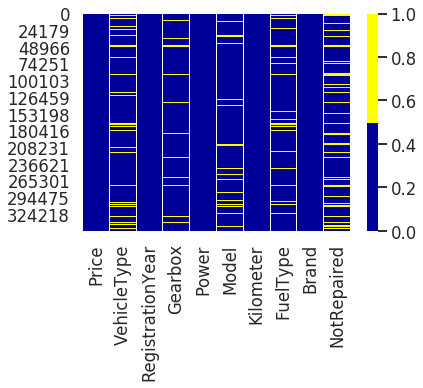

In [10]:
cols = df.columns 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

Не факт, что в тех данных, в которых пропуски не отображаются, нет нулей, которые по факту являются отсутствующими данными. Требуется обработка и изучение пропусков. 

In [11]:
def unique_rows (data):
    for column in data: 
        print ('Уникальные значения', column)
        print (data[column].unique())
        print ()

In [12]:
unique_rows(df)

Уникальные значения Price
[  480 18300  9800 ... 12395 18429 10985]

Уникальные значения VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Уникальные значения RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]

Уникальные значения G

Видим следующее: 
- VehicleType - пропуски
- RegistrationYear - некорректные значения, множество
- Gearbox - пропуски
- Power - пропуски, некорректные значения (2, 5 и т.д.)
- FuelType - пропуски 
- NotRepaired - пропуски

Оценим распределение значений: диапазон, нормальность, выбросы. Функция num_info даст визуальное представление о данных: describe, kde, boxplot, Q-Q-plot. По умолчанию - для всех числовых столбцов.

In [13]:
# def num_info(df, cols=None):
#     if cols == None:
#         cols = [col for col in df.columns if df[col].dtype in ['float64','int64']]

#     df_descr = round(df[cols].describe(), 2)
    
#     f, ax = plt.subplots(len(cols), 4, gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
#     f.set_figheight(6 * len(cols))
#     f.set_figwidth(20)
    
#     for i, col in enumerate(cols):
#         if len(cols) == 1:
#             ax_xy = [ax[0],ax[1],ax[2],ax[3]]
#         else:
#             ax_xy = [ax[i,0],ax[i,1],ax[i,2],ax[i,3]]
        
#         the_table = ax_xy[0].table(
#             #Содержимое таблицы в виде списка списков строк
#             cellText = [list(x) for x in df_descr.loc[:,col].values.reshape(df_descr.shape[0],1).astype('str')],
#             rowLabels = list(df_descr.index),
#             colLabels = [col],
#             loc = 'upper center',
#             colWidths = [0.8],
#         )
#         the_table.scale(1, 2)
#         the_table.auto_set_font_size(False)
#         the_table.set_fontsize(16)
#         ax_xy[0].grid(False)
#         ax_xy[0].axis('off')

#         sns.kdeplot(
#             x = col,
#             data = df,
#             shade = True,
#             linewidth = 3,
#             ax = ax_xy[1]
#         )
    
#         sns.boxplot(
#             x = col,
#             data = df,
#             orient = 'h',
#             ax = ax_xy[2]
#         )
#         sm.qqplot(df[df[col].notna()][col], line='45', fit=True, ax=ax_xy[3])

#     plt.show()

In [14]:
#num_info(df)

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера ❌</b> 

~~Код выдает ошибку. Скорее всего, проблема в несоответствии версий. См. раздел ноушна «Установка окружения - как избежать конфликта версий библиотек».~~
</div>


<div style="background: #eeeeee">
<font color='blue'> 
    <b><u>КОММЕНТАРИЙ СТУДЕНТА:</u></b>
<font color='blue'><br>
Жаль, что функция не сработала, у меня на локальной машине все по-прежнему работает хорошо. 

<div style="background: #eeeeee">
<font color='blue'> 
    <b><u>КОММЕНТАРИЙ СТУДЕНТА:</u></b>
<font color='blue'><br>В таком случае разделим написанную и закомментированную функцию на операции и посмотрим результат.

count    309329.000000
mean       4486.937196
std        4564.852796
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

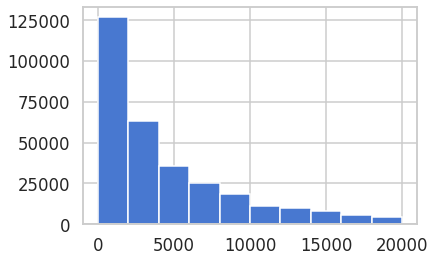

In [15]:
display(df['Price'].describe())
df['Price'].hist()

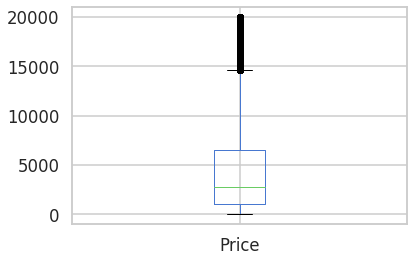

In [16]:
df.boxplot(column='Price')
plt.show() 

count    309329.000000
mean     127217.735809
std       38532.941010
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

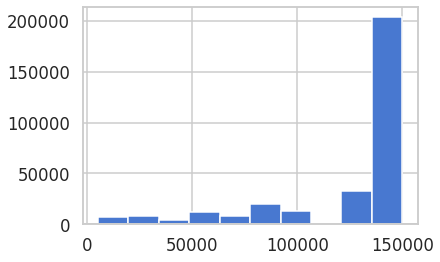

In [17]:
display(df['Kilometer'].describe())
df['Kilometer'].hist()

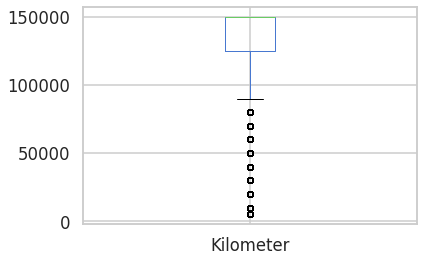

In [18]:
df.boxplot(column='Kilometer')
plt.show() 

count    309329.000000
mean       2004.360105
std          92.541399
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

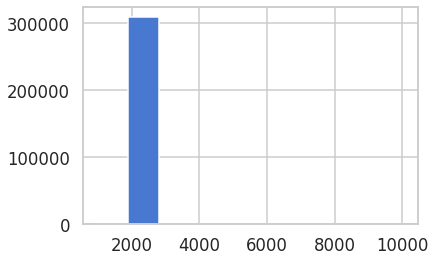

In [19]:
display(df['RegistrationYear'].describe())
df['RegistrationYear'].hist()

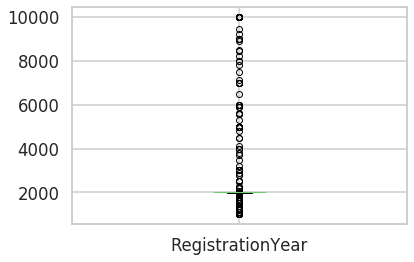

In [20]:
df.boxplot(column='RegistrationYear')
plt.show() 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94c13d9690>,
      dtype=object)

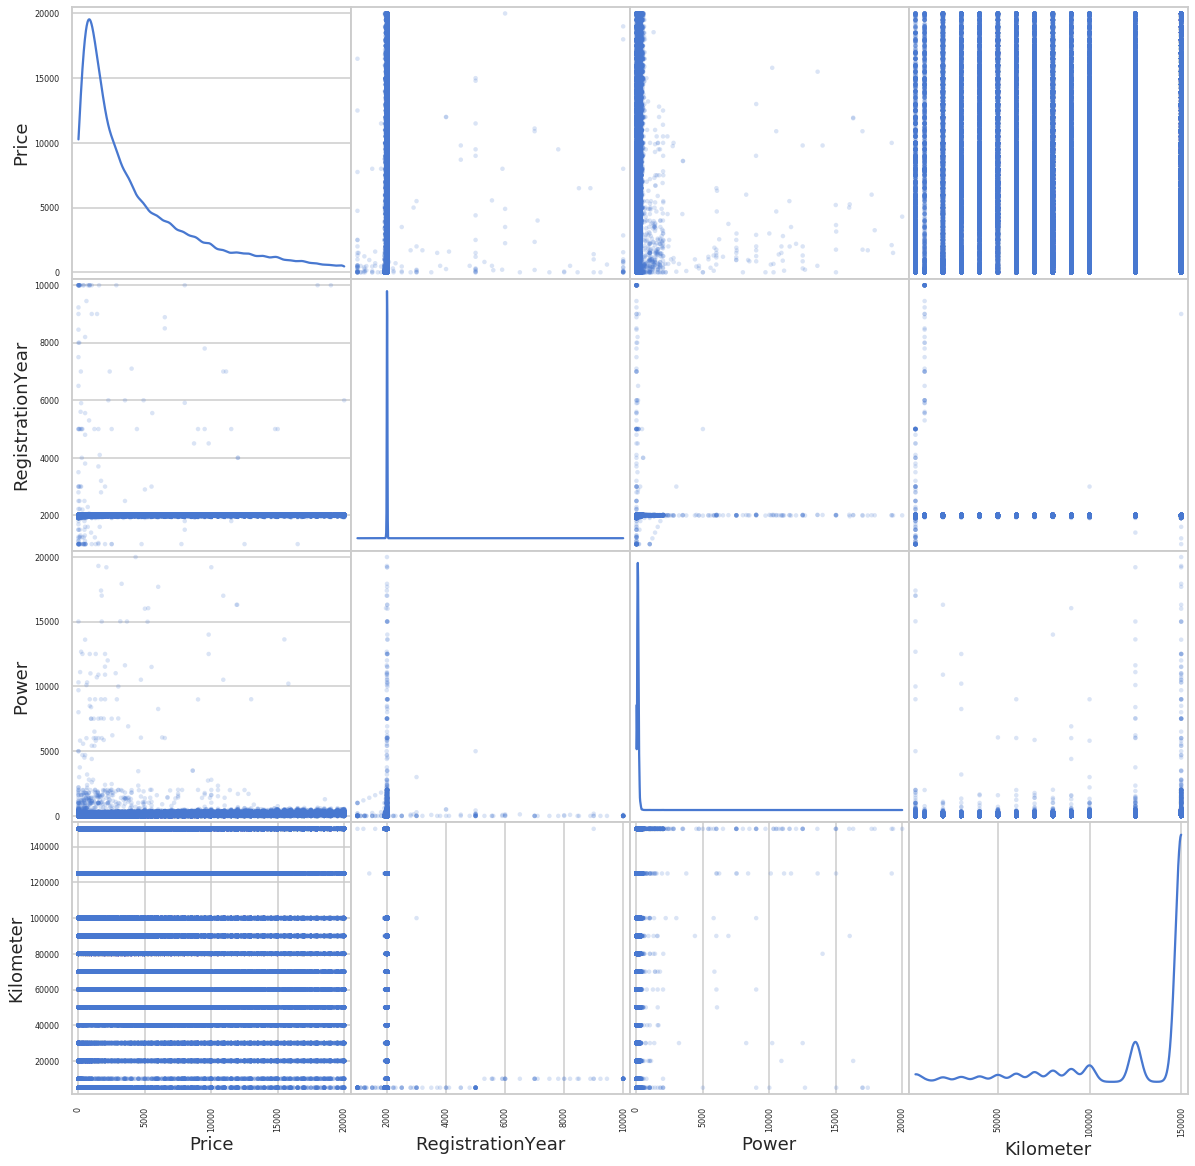

In [21]:
scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal='kde')

Можем также взглянуть на матрицу корреляции, но половина столбцов у нас - категориальные. 

In [22]:
df.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.025714,0.147634,-0.325592
RegistrationYear,0.025714,1.000000,-0.000896,-0.052516
Power,0.147634,-0.000896,1.000000,0.026446
Kilometer,-0.325592,-0.052516,0.026446,1.000000


Почти всегда существует фактическая корреляция между годом и пробегом, например. Удивительно, что здесь ее нет (т.е. она всего лишь -0.33). Вопрос в том, насколько корректно указан пробег заполнявшим анкету автовладельцем :)

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера ⚠️</b> 

~~Проверь, разве корреляция между годом и пробегом получилась -0.33?~~
</div>



<div style="background: #eeeeee">
<font color='blue'> 
    <b><u>КОММЕНТАРИЙ СТУДЕНТА:</u></b>
<font color='blue'><br>Корреляция между годом и пробегом и того меньше: -0.05.

Так, посмотрев на датасет более пристально увидим, что многие данные о типе кузова, например, годе выпуска и т.д. заполнены неверно, типы кузова не соответствуют моделям, даже продававшимся на европейском и американском рынках. Очевидно, данные в датасет вносились автовладельцами, а не оценщиками. Кроме того, наиболее влияющие на цену автомобиля факторы - ключевые позиции комплектации (например, наличие подушек безопасности, климат-контроля, электронных систем разного рода) - здесь вообще не указаны. Но мы не будем исправлять данные, а будем исходить из учебной задачи, которая перед нами стоит - изучение ранее не изученных моделей машинного обучения, их построение и сравнение между собой. 

Поэтому поступим следующим образом: заполним пропуски, исправим или удалим, если количество незначительно, явно некорректные значения года выпуска, мощности и перейдем к моделям. 

#### Заполним пропуски и исправим ошибки

Сначала найдем и удалим все строки, в которых и VehicleType, и Gearbox, и Model не заполнены.

In [23]:
df.loc[(df['VehicleType'].isna()) & (df['Gearbox'].isna()) & (df['Model'].isna())]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
306,200,NaN,2009,NaN,0,NaN,10000,NaN,sonstige_autos,NaN
522,0,NaN,2000,NaN,0,NaN,150000,NaN,volvo,NaN
538,2600,NaN,2005,NaN,0,NaN,125000,NaN,chevrolet,NaN
552,50,NaN,1985,NaN,0,NaN,150000,NaN,trabant,NaN
622,0,NaN,1111,NaN,0,NaN,5000,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
353961,200,NaN,1910,NaN,0,NaN,5000,petrol,sonstige_autos,NaN
354073,1750,NaN,1995,NaN,0,NaN,100000,NaN,sonstige_autos,NaN
354162,1500,NaN,1995,NaN,0,NaN,150000,NaN,volkswagen,NaN
354338,180,NaN,1995,NaN,0,NaN,125000,petrol,opel,NaN


У многих из них даже бренд - sonstige autos (прочие автомобили), поэтому мы не восстановим вообще никакой информации, у нас есть только год, пробег и цена (да и та не везде).

In [24]:
indexes_to_delete = df.loc[(df['VehicleType'].isna()) & (df['Gearbox'].isna()) & (df['Model'].isna())].index.tolist()
df = df.drop(index=indexes_to_delete)

_RegistrationYear_

In [25]:
df.loc[(df['RegistrationYear'] < 1910) | (df['RegistrationYear'] > 2020)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
12946,49,NaN,5000,NaN,0,golf,5000,NaN,volkswagen,NaN
16062,190,NaN,1000,NaN,0,mondeo,5000,NaN,ford,NaN
17271,700,NaN,9999,NaN,0,other,10000,NaN,opel,NaN
18224,7999,NaN,1500,manual,224,impreza,5000,NaN,subaru,NaN
18259,300,NaN,2200,NaN,0,twingo,5000,NaN,renault,NaN
...,...,...,...,...,...,...,...,...,...,...
338829,50,NaN,3000,NaN,3000,golf,100000,NaN,volkswagen,yes
340548,0,NaN,3500,manual,75,NaN,5000,petrol,sonstige_autos,NaN
340759,700,NaN,1600,manual,1600,a3,150000,petrol,audi,no
341791,1,NaN,3000,NaN,0,zafira,5000,NaN,opel,NaN


Посмотрим записи с неверными годами регистрации и удалим. Заполнять эти данные не будем, т.к. их, во-первых, немного, а во-вторых, это один из основных факторов, который влияет на цену автомобиля.

In [26]:
indexes_to_delete = df.loc[(df['RegistrationYear'] < 1910) | (df['RegistrationYear'] > 2020)].index.tolist()
df = df.drop(index=indexes_to_delete)

In [27]:
df.loc[(df['RegistrationYear'] < 1910) | (df['RegistrationYear'] > 2020)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired


_Model_

In [28]:
df['Model'].isna().sum()

15993

Заполним пропуски в моделях модой модели по автомобильному бренду.

In [29]:
models=df.groupby(['Brand', 'Model'], as_index=False).aggregate(
    {'Power': 'count'}).sort_values(by=['Brand', 'Power'], ascending=False).groupby('Brand').first()
models

,Model,Power
Brand,,
alfa_romeo,156,570
audi,a4,8268
bmw,3er,16695
chevrolet,other,898
chrysler,other,362
...,...,...
suzuki,other,1006
toyota,yaris,926
trabant,601,393


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Или так:
    
    .. = df.groupby('Brand')['Model'].agg(pd.Series.mode)
</div>



In [30]:
models_dict = dict(zip(list(models.index), list(models.Model)))
models_dict

{'alfa_romeo': '156',
 'audi': 'a4',
 'bmw': '3er',
 'chevrolet': 'other',
 'chrysler': 'other',
 'citroen': 'other',
 'dacia': 'logan',
 'daewoo': 'matiz',
 'daihatsu': 'cuore',
 'fiat': 'punto',
 'ford': 'focus',
 'honda': 'civic',
 'hyundai': 'i_reihe',
 'jaguar': 'other',
 'jeep': 'grand',
 'kia': 'other',
 'lada': 'niva',
 'lancia': 'ypsilon',
 'land_rover': 'freelander',
 'mazda': '3_reihe',
 'mercedes_benz': 'c_klasse',
 'mini': 'cooper',
 'mitsubishi': 'colt',
 'nissan': 'micra',
 'opel': 'corsa',
 'peugeot': '2_reihe',
 'porsche': 'cayenne',
 'renault': 'twingo',
 'rover': 'other',
 'saab': 'other',
 'seat': 'ibiza',
 'skoda': 'fabia',
 'smart': 'fortwo',
 'subaru': 'impreza',
 'suzuki': 'other',
 'toyota': 'yaris',
 'trabant': '601',
 'volkswagen': 'golf',
 'volvo': 'v40'}

In [31]:
for model in models_dict.keys(): 
    df.loc[(df['Model'].isna()), 'Model'] = models_dict[model]

In [32]:
df['Model'].isna().sum()

0

_FuelType - пропуски заменим на моду._

In [33]:
df.FuelType.isna().sum()

28930

In [34]:
df.FuelType.value_counts()

petrol      187408
gasoline     84632
lpg           4876
cng            522
hybrid         221
other          190
electric        88
Name: FuelType, dtype: int64

Подавляющее большинство автомобилей в этой выборке - на бензине (обозначены как petrol и gasoline), удивительно, что нет автомобилей на дизельном топливе (если только в other, 153 шт.). Полагаю, что, возможно gasoline здесь это дизельное топливо, но по факту это обозначение неверное - по-настоящему газолиновых автомобилей в мире практически не существует. Не будем менять обозначения, заполним пропуски модой - petrol. В России дизельный автомобиль менее 5 лет возрастом был бы дороже бензинового, более 5 лет - дешевле, т.к. топливная аппаратура очень дорога в ремонте, а качество российского дизеля для легковых дизелей стандарта Евро-6 ужасное. 

У нас не получится восстановить тип топлива по модели автомобиля, т.к. многие модели выпускаются как в бензиновых, так и в иных версиях - в одном и том же типе кузова, в одних и тех же комплектациях. Пример: Volkswagen Golf (типы кузова: хетчбек 3 двери, 5 дверей, универсал; типы топлива: бензин, дизель, cng, КПП: 5-ступенчатая МКПП, 4-ступенчатая АКПП, 6-ступенчатая АКПП, 7-ступенчатая АКПП, 6-ступенчатая МКПП - практически всех сочетаниях между собой).

In [35]:
df['FuelType'] = df['FuelType'].fillna('petrol')

In [36]:
df.FuelType.isna().sum()

0

_Gearbox - пропуски заменим на моду по модели_

In [37]:
df.Gearbox.isna().sum()

14775

In [38]:
df.Gearbox.value_counts()

manual    232750
auto       59342
Name: Gearbox, dtype: int64

Сделаем словарь из названия модели и наиболее типичной коробки передач для этой модели.

In [39]:
gearbox=df.pivot_table(index=['Model'], columns='Gearbox', values='Power', aggfunc='count').fillna(0)
gearbox['gearbox_moda']=gearbox['manual']-gearbox['auto']
gearbox.loc[gearbox['gearbox_moda'] > 0, 'gearbox_type'] = 'manual'
gearbox.loc[gearbox['gearbox_moda'] <= 0, 'gearbox_type'] = 'auto'
display(gearbox['gearbox_type'].value_counts())
gearbox_dict = dict(zip(list(gearbox.index), list(gearbox.gearbox_type)))
gearbox_dict

manual    215
auto       35
Name: gearbox_type, dtype: int64

{'100': 'manual',
 '145': 'manual',
 '147': 'manual',
 '156': 'manual',
 '159': 'manual',
 '1_reihe': 'manual',
 '1er': 'manual',
 '200': 'manual',
 '2_reihe': 'manual',
 '300c': 'auto',
 '3_reihe': 'manual',
 '3er': 'manual',
 '4_reihe': 'manual',
 '500': 'manual',
 '5_reihe': 'manual',
 '5er': 'auto',
 '601': 'manual',
 '6_reihe': 'manual',
 '6er': 'auto',
 '7er': 'auto',
 '80': 'manual',
 '850': 'manual',
 '90': 'manual',
 '900': 'manual',
 '9000': 'manual',
 '911': 'manual',
 'a1': 'manual',
 'a2': 'manual',
 'a3': 'manual',
 'a4': 'manual',
 'a5': 'manual',
 'a6': 'auto',
 'a8': 'auto',
 'a_klasse': 'manual',
 'accord': 'manual',
 'agila': 'manual',
 'alhambra': 'manual',
 'almera': 'manual',
 'altea': 'manual',
 'amarok': 'manual',
 'antara': 'manual',
 'arosa': 'manual',
 'astra': 'manual',
 'auris': 'manual',
 'avensis': 'manual',
 'aveo': 'manual',
 'aygo': 'manual',
 'b_klasse': 'manual',
 'b_max': 'manual',
 'beetle': 'manual',
 'berlingo': 'manual',
 'bora': 'manual',
 'box

In [40]:
for gearbox in gearbox_dict.keys(): 
    df.loc[(df['Gearbox'].isna()), 'Gearbox'] = gearbox_dict[gearbox]

In [41]:
df.Gearbox.isna().sum()

0

_VehicleType_

VehicleType отражает функциональность автомобиля, также влияет на цену. Найдем моду по модели и заменим пропуски на моду. Чаще всего одна и та же модель выпускалась в одном типе кузова, или в нескольких, но один из них преобладал по причине универсальности в данном классе (хетчбеки в классе В, седаны в классе С и Д, универсалы в классе Д - на европейском рынке).

In [42]:
df.VehicleType.isna().sum()

32097

In [43]:
vtype=df.groupby(['Model', 'VehicleType'], as_index=False).aggregate(
    {'Power': 'count'}).sort_values(by=['Model', 'Power'], ascending=False).groupby('Model').first()
vtype

,VehicleType,Power
Model,,
100,sedan,247
145,small,18
147,sedan,321
156,sedan,3448
159,wagon,135
...,...,...
yaris,small,787
yeti,suv,154
ypsilon,small,163


In [44]:
vtype_dict = dict(zip(list(vtype.index), list(vtype.VehicleType)))
vtype_dict

{'100': 'sedan',
 '145': 'small',
 '147': 'sedan',
 '156': 'sedan',
 '159': 'wagon',
 '1_reihe': 'small',
 '1er': 'sedan',
 '200': 'sedan',
 '2_reihe': 'small',
 '300c': 'wagon',
 '3_reihe': 'sedan',
 '3er': 'sedan',
 '4_reihe': 'wagon',
 '500': 'small',
 '5_reihe': 'bus',
 '5er': 'sedan',
 '601': 'sedan',
 '6_reihe': 'wagon',
 '6er': 'coupe',
 '7er': 'sedan',
 '80': 'sedan',
 '850': 'wagon',
 '90': 'sedan',
 '900': 'convertible',
 '9000': 'sedan',
 '911': 'coupe',
 'a1': 'small',
 'a2': 'small',
 'a3': 'sedan',
 'a4': 'wagon',
 'a5': 'coupe',
 'a6': 'wagon',
 'a8': 'sedan',
 'a_klasse': 'sedan',
 'accord': 'sedan',
 'agila': 'small',
 'alhambra': 'bus',
 'almera': 'sedan',
 'altea': 'bus',
 'amarok': 'suv',
 'antara': 'suv',
 'arosa': 'small',
 'astra': 'sedan',
 'auris': 'sedan',
 'avensis': 'wagon',
 'aveo': 'small',
 'aygo': 'small',
 'b_klasse': 'bus',
 'b_max': 'bus',
 'beetle': 'sedan',
 'berlingo': 'bus',
 'bora': 'sedan',
 'boxster': 'convertible',
 'bravo': 'sedan',
 'c1': 's

In [45]:
for type in vtype_dict.keys(): 
    df.loc[(df['VehicleType'].isna()), 'VehicleType'] = vtype_dict[type]

In [46]:
df.VehicleType.isna().sum()

0

_Power_

Посмотрим на значение лошадиных сил менее 35 л.с. и более 500 (это встречается крайне редко для легковых автомобилей).

In [47]:
df.loc[df.Power < 35].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,NaN
15,450,small,1910,manual,0,ka,5000,petrol,ford,NaN
32,245,sedan,1994,manual,0,golf,150000,petrol,volkswagen,no
37,1500,sedan,2016,manual,0,kangoo,150000,gasoline,renault,no
40,0,sedan,1990,manual,0,corsa,150000,petrol,opel,NaN


In [48]:
df.loc[(df['Power']>500)].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2102,0,sedan,1999,manual,1799,vectra,150000,petrol,opel,yes
3746,0,sedan,2017,manual,750,156,150000,petrol,smart,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,NaN


Видим, что это нули, а также числа, которые являются, скорее всего, объемом двигателя в кубических сантиметрах (очень похоже), поэтому заменим на медиану по модели. 

In [49]:
power_df = (df.loc[(df['Power']<500) & (df['Power']>35)]).groupby('Model')['Power'].agg('median').reset_index().set_index('Model')
power_dict = dict(zip(list(power_df.index), list(power_df.Power)))
power_dict

{'100': 133.0,
 '145': 103.0,
 '147': 120.0,
 '156': 110.0,
 '159': 170.0,
 '1_reihe': 60.0,
 '1er': 143.0,
 '200': 182.0,
 '2_reihe': 90.0,
 '300c': 218.0,
 '3_reihe': 109.0,
 '3er': 150.0,
 '4_reihe': 136.0,
 '500': 69.0,
 '5_reihe': 143.0,
 '5er': 184.0,
 '601': 40.5,
 '6_reihe': 125.0,
 '6er': 333.0,
 '7er': 242.0,
 '80': 111.5,
 '850': 144.0,
 '90': 136.0,
 '900': 143.0,
 '9000': 165.0,
 '911': 300.0,
 'a1': 95.0,
 'a2': 75.0,
 'a3': 125.0,
 'a4': 143.0,
 'a5': 190.0,
 'a6': 179.0,
 'a8': 275.0,
 'a_klasse': 95.0,
 'accord': 148.0,
 'agila': 65.0,
 'alhambra': 116.0,
 'almera': 90.0,
 'altea': 125.0,
 'amarok': 163.0,
 'antara': 150.0,
 'arosa': 50.0,
 'astra': 101.0,
 'auris': 124.0,
 'avensis': 129.0,
 'aveo': 86.0,
 'aygo': 68.0,
 'b_klasse': 116.0,
 'b_max': 100.5,
 'beetle': 105.0,
 'berlingo': 90.0,
 'bora': 115.0,
 'boxster': 224.0,
 'bravo': 104.5,
 'c1': 68.0,
 'c2': 68.0,
 'c3': 73.0,
 'c4': 109.0,
 'c5': 136.0,
 'c_klasse': 143.0,
 'c_max': 116.0,
 'c_reihe': 145.0,
 'c

In [50]:
for model in power_dict.keys(): 
    df.loc[((df['Power']>500) | (df['Power']<35)) & (df['Model'] == model), 'Power'] = power_dict[model]

_NotRepaired_

Была ли машина в ремонте (скорее всего, кузовном), т.к. слесарный ремонт был для 99% автомобилей в той или иной степени, и это ОК.

In [51]:
df.NotRepaired.value_counts()

no     211111
yes     33331
Name: NotRepaired, dtype: int64

In [52]:
df.NotRepaired.isna().sum()

62425

Большинство автомобилей в кузовном ремонте было. Проверим эту гипотезу и заменим.

In [53]:
not_repaired = df.pivot_table(index=['RegistrationYear'], columns='NotRepaired', values='Power', aggfunc='count').fillna(0)
not_repaired['repair_moda']=not_repaired['yes']-not_repaired['no']
not_repaired.loc[not_repaired['repair_moda'] > 0, 'repair'] = 'yes'
not_repaired.loc[not_repaired['repair_moda'] <= 0, 'repair'] = 'no'
display(not_repaired['repair'].value_counts())
not_repaired.head()

no     89
yes     3
Name: repair, dtype: int64

NotRepaired,no,yes,repair_moda,repair
RegistrationYear,,,,
1910,6.0,6.0,0.0,no
1919,0.0,1.0,1.0,yes
1923,2.0,0.0,-2.0,no
1925,1.0,0.0,-1.0,no
1929,2.0,2.0,0.0,no


In [54]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')
df.NotRepaired.isna().sum()

0

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Прекрасно, пропуски обработаны!
</div>


_Price_

In [55]:
df.Price.describe()

count    306867.000000
mean       4510.171788
std        4568.466267
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

Данные в столбце Price содержат нулевые значения, максимальное значение - 20000 евро, что вполне может иметь место для автомобиля с пробегом.

<AxesSubplot:ylabel='Frequency'>

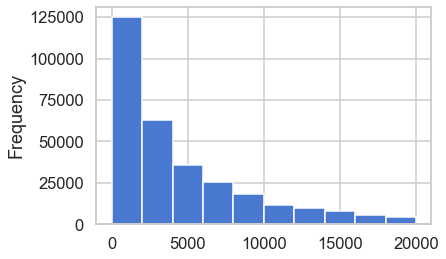

In [56]:
df.Price.plot(kind='hist')

In [57]:
df.loc[df['Price']==0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
7,0,sedan,1980,manual,50.0,other,40000,petrol,volkswagen,no
40,0,sedan,1990,manual,60.0,corsa,150000,petrol,opel,no
111,0,sedan,2017,manual,101.0,golf,5000,petrol,volkswagen,no
115,0,small,1999,manual,110.0,156,5000,petrol,volkswagen,no
152,0,bus,2004,manual,101.0,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354205,0,sedan,2000,manual,65.0,corsa,150000,petrol,opel,yes
354238,0,small,2002,manual,60.0,fiesta,150000,petrol,ford,no
354248,0,small,1999,manual,53.0,swift,150000,petrol,suzuki,no
354277,0,small,1999,manual,37.0,arosa,150000,petrol,seat,yes


Итак, есть около 10 тыс.записей с нулевым целевым признаком, удалим их.

In [58]:
indexes_to_delete = df.loc[df['Price']==0].index.tolist()
df = df.drop(index=indexes_to_delete)

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Да, нулевые цены подозрительны :)
</div>



In [59]:
df.loc[df['Price']==0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired


Закодируем коробку передач в 0 или 1.

In [60]:
df['GearboxManual'] = 0
df.loc[df['Gearbox'] == 'manual', 'GearboxManual'] = 1
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,GearboxManual
0,480,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,no,1
1,18300,coupe,2011,manual,190.0,156,125000,gasoline,audi,yes,1
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,no,0
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,1
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,1


In [61]:
df['NotRepaired'] = 0
df.loc[df['NotRepaired'] == 'no', 'NotRepaired'] = 0
df.loc[df['NotRepaired'] == 'yes', 'NotRepaired'] = 1
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,GearboxManual
0,480,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,0,1
1,18300,coupe,2011,manual,190.0,156,125000,gasoline,audi,0,1
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,0,0
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,0,1
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,0,1


In [62]:
df=df.drop('Gearbox', axis=1)

Удалим также данные о бренде, т.к. он однозначно определяется моделью. Данные о модели удалять не будем, т.к. при прочих равных параметрах (из тех, что есть у нас в данных) будто бы "одинаковые" автомобили разных моделей будут стоить по-разному из-за бренда и классов автомобилей.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Замечу, что брендов всего 40, в то время как моделей – более 200. Можно поэкспериментировать: посмотреть на качество моделей с разными наборами признаков (например, с признаком Brand и без него) и выбрать оптимальное решение.
</div>



In [63]:
df=df.drop('Brand', axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Power,Model,Kilometer,FuelType,NotRepaired,GearboxManual
0,480,sedan,1993,101.0,golf,150000,petrol,0,1
1,18300,coupe,2011,190.0,156,125000,gasoline,0,1
2,9800,suv,2004,163.0,grand,125000,gasoline,0,0
3,1500,small,2001,75.0,golf,150000,petrol,0,1
4,3600,small,2008,69.0,fabia,90000,gasoline,0,1


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298419 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             298419 non-null  int64  
 1   VehicleType       298419 non-null  object 
 2   RegistrationYear  298419 non-null  int64  
 3   Power             298419 non-null  float64
 4   Model             298419 non-null  object 
 5   Kilometer         298419 non-null  int64  
 6   FuelType          298419 non-null  object 
 7   NotRepaired       298419 non-null  int64  
 8   GearboxManual     298419 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 22.8+ MB


In [65]:
def func_downcast(column_name): 
    df[column_name] = pd.to_numeric(df[column_name], downcast='integer')

In [66]:
column_list=['NotRepaired', 'GearboxManual', 'RegistrationYear', 'Power', 'Kilometer', 'Price']
for column in column_list: 
    func_downcast(column)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298419 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             298419 non-null  int16  
 1   VehicleType       298419 non-null  object 
 2   RegistrationYear  298419 non-null  int16  
 3   Power             298419 non-null  float64
 4   Model             298419 non-null  object 
 5   Kilometer         298419 non-null  int32  
 6   FuelType          298419 non-null  object 
 7   NotRepaired       298419 non-null  int8   
 8   GearboxManual     298419 non-null  int8   
dtypes: float64(1), int16(2), int32(1), int8(2), object(3)
memory usage: 14.2+ MB


#### Вывод по обработке данных

Провели обработку данных, удалили неинформативные записи, восстановили пропущенные значения. <div> 
    Уменьшили использование памяти для более быстрой работы с признаками.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Блестящая предобработка данных 👏👏👏
</div>



## Обучение моделей

Примечания к заданию:
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.

Обучим разные модели. Для каждой попробуем различные гиперпараметры.

 - Linear Regression
 - Ridge Regression 
 - Decision Tree Regressor
 - CatBoost Regressor
 - LGBM Regressor

В качестве метрики возьмем MSE, и в конце сведем все в таблицу, где MSE превратим в RMSE. Будем также использовать кросс-валидацию.

Сделаем копию исходного датафрейма.

In [67]:
data = df.copy()
data.head()

,Price,VehicleType,RegistrationYear,Power,Model,Kilometer,FuelType,NotRepaired,GearboxManual
0,480,sedan,1993,101.0,golf,150000,petrol,0,1
1,18300,coupe,2011,190.0,156,125000,gasoline,0,1
2,9800,suv,2004,163.0,grand,125000,gasoline,0,0
3,1500,small,2001,75.0,golf,150000,petrol,0,1
4,3600,small,2008,69.0,fabia,90000,gasoline,0,1


Отделим целевые признаки от иных, закодируем категориальные.

In [68]:
original_features = data.drop('Price', axis=1)
ohe_features = pd.get_dummies(original_features, drop_first=True)
target = data['Price']

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

OHE-кодирование проведено корректно.
</div>


In [69]:
ohe_features.head()

,RegistrationYear,Power,Kilometer,NotRepaired,GearboxManual,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,...,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol
0,1993,101.0,150000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2011,190.0,125000,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2004,163.0,125000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2001,75.0,150000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2008,69.0,90000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [70]:
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=7777777)

ohe_features_train = ohe_features.loc[original_features_train.index, :]
ohe_features_test = ohe_features.loc[original_features_test.index, :]

In [71]:
ohe_features_train.shape

(223814, 267)

In [72]:
ohe_features_test.shape

(74605, 267)

Перейдем к моделям.

#### Linear Regression

In [73]:
start_time = time.time()
regressor = LinearRegression()

c_v_RMSE_LR = (cross_val_score(regressor, ohe_features_train, target_train, cv=5, n_jobs=-1,
                                       scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from cross-validation of LinearRegression =', c_v_RMSE_LR)
elapsed_time_LR = time.time() - start_time 

Mean RMSE from cross-validation of LinearRegression = 2870.2783609850544


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Кросс-валидация проведена верно, отлично.
</div>



#### Ridge Regression

In [74]:
start_time = time.time()
regressor = Ridge()
hyperparams = [{'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error', n_jobs=-1)
clf.fit(ohe_features_train, target_train)

print("Best parameters:")
print()
print(clf.best_params_)
print()
print("Grid scores:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_R = (max(means)*-1) ** 0.5

elapsed_time_R = time.time() - start_time 

Best parameters:

{'solver': 'svd'}

Grid scores:

2870.275243 for {'solver': 'auto'}
2870.275243 for {'solver': 'svd'}
2870.275243 for {'solver': 'cholesky'}
4292.324675 for {'solver': 'lsqr'}
3510.033512 for {'solver': 'sparse_cg'}



<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Отлично!
</div>



#### Decision Tree Regressor

In [75]:
start_time = time.time()

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[7777777]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error', n_jobs=-1)
clf.fit(ohe_features_train, target_train)
print("Best parameters:")
print()
print(clf.best_params_)
print()
print("Grid scores:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5

elapsed_time_DTR = time.time() - start_time 

Best parameters:

{'criterion': 'mse', 'max_depth': 14, 'random_state': 7777777}

Grid scores:

3357.675605 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 7777777}
3055.474569 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 7777777}
2724.565448 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 7777777}
2524.639706 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 7777777}
2379.380093 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 7777777}
2288.796044 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 7777777}
2224.213470 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 7777777}
2182.435881 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 7777777}
2142.667220 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 7777777}
2118.339621 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 7777777}
2103.157643 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 7777777}
2089.989871 for {'criterion': 'mse', 'max_d

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера ❌</b> 

~~При OHE-кодировании растет число признаков, из-за этого модели, как правило, работают медленнее и менее эффективно. OHE-кодирование используется для линейных моделей, так как они не могут корректно работать с категориальными признаками, закодированными порядковым образом. Для остальных моделей (вкл. решающие деревья, случайный лес, бустинг) предпочтительно использовать **порядковое** кодирование категориальных признаков.~~

~~При желании можешь поэкспериментировать и посмотреть, как изменится качество и время работы модели решающего дерева, если вместо порядкового кодирования использовать OHE. ~~
</div>


Получили лучшее: <div>
2004.328176 for {'criterion': 'mse', 'max_depth': 16 ...} <div>
Wall time: 5min 42s<div>

<div style="background: #eeeeee">
<font color='blue'> 
    <b><u>КОММЕНТАРИЙ СТУДЕНТА:</u></b>
<font color='blue'><br>
Проэкспериментируем с деревом на основе признаков, закодированных порядковым кодированием. 

In [76]:
df.head()

,Price,VehicleType,RegistrationYear,Power,Model,Kilometer,FuelType,NotRepaired,GearboxManual
0,480,sedan,1993,101.0,golf,150000,petrol,0,1
1,18300,coupe,2011,190.0,156,125000,gasoline,0,1
2,9800,suv,2004,163.0,grand,125000,gasoline,0,0
3,1500,small,2001,75.0,golf,150000,petrol,0,1
4,3600,small,2008,69.0,fabia,90000,gasoline,0,1


In [77]:
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Model']
cat_features = original_features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
ordinal_features = original_features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]
ordinal_features_train = ordinal_features.loc[original_features_train.index, :]
ordinal_features_test = ordinal_features.loc[original_features_test.index, :]

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2 ✔️</b> 

С порядковым кодированием все в порядке, отлично.
</div>



In [78]:
ordinal_features_train.head()

,VehicleType,RegistrationYear,Power,Model,Kilometer,FuelType,NotRepaired,GearboxManual
98434,4.0,2016,60.0,176.0,100000,2.0,0,1
311588,5.0,1997,45.0,83.0,125000,6.0,0,1
152513,7.0,2006,140.0,163.0,150000,2.0,0,1
197909,4.0,2017,101.0,116.0,150000,6.0,0,1
130527,4.0,2003,75.0,101.0,150000,6.0,0,1


In [79]:
ordinal_features_test.head()

,VehicleType,RegistrationYear,Power,Model,Kilometer,FuelType,NotRepaired,GearboxManual
166054,7.0,1998,75.0,42.0,150000,6.0,0,1
34669,0.0,2006,75.0,116.0,40000,6.0,0,1
183775,2.0,1989,90.0,3.0,40000,6.0,0,1
261226,7.0,2008,109.0,10.0,150000,2.0,0,1
135269,5.0,2009,75.0,173.0,150000,2.0,0,1


In [80]:
%%time
regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[7777777]}]
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 13, 'random_state': 7777777}

Grid scores on development set:

3357.675605 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 7777777}
3055.474569 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 7777777}
2726.262941 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 7777777}
2519.549091 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 7777777}
2381.844556 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 7777777}
2295.707238 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 7777777}
2232.651711 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 7777777}
2186.471458 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 7777777}
2150.795368 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 7777777}
2125.664126 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 7777777}
2112.373902 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 7777

<div style="background: #eeeeee">
<font color='blue'> 
    <b><u>КОММЕНТАРИЙ СТУДЕНТА:</u></b>
<font color='blue'><br>
Получили: <div>
2108.447396 {'criterion': 'mse', 'max_depth': 13, 'random_state': 7777777}
<div>

<div style="background: #eeeeee">
<font color='blue'> 
    <b><u>КОММЕНТАРИЙ СТУДЕНТА:</u></b>
<font color='blue'><br>
Метрика ухудшилась.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2 ✔️</b> 

Да, качество упало, но время работы сильно сократилось.
</div>




#### CatBoost Regressor

In [81]:
start_time = time.time()
regressor = CatBoostRegressor(learning_rate=0.5, iterations = 200, random_state=7777777, verbose=False, 
                              cat_features=['VehicleType','FuelType','Model']) 

cv_RMSE_CBR_original = (cross_val_score(regressor, original_features_train, target_train, cv=5, n_jobs=-1,
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR_original)
elapsed_time_CBR = time.time() - start_time 

Mean RMSE from CV of CatBoostRegressor = 1859.1760502918407


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Верно, модель CatBoostRegressor умеет работать с категориальными признаками 👍
</div>


#### LGBM Regressor

In [82]:
start_time = time.time()
regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[7777777]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters:")
print()
print(clf.best_params_)
print()
print("Grid scores:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5
elapsed_time_LGBMR = time.time() - start_time 

Best parameters:

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 7777777}

Grid scores:

1922.649023 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 7777777}
1834.774028 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 7777777}
1803.593727 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 7777777}
1853.089577 for {'learning_rate': 0.3, 'num_leaves': 31, 'random_state': 7777777}
1807.143911 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 7777777}
1800.505618 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 7777777}
1848.040916 for {'learning_rate': 0.5, 'num_leaves': 31, 'random_state': 7777777}
1829.870864 for {'learning_rate': 0.5, 'num_leaves': 100, 'random_state': 7777777}
1835.585933 for {'learning_rate': 0.5, 'num_leaves': 200, 'random_state': 7777777}



<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера ❌</b> 

~~Как и для модели решающего дерева, используй **порядковое** кодирование категориальных признаков.~~
</div>


<div style="background: #eeeeee">
<font color='blue'> 
    <b><u>КОММЕНТАРИЙ СТУДЕНТА:</u></b>
<font color='blue'><br>
Исправили признаки в тексте ячейки выше на признаки порядкового кодирования.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2 ✔️</b> 

Для модели LGBMRegressor можно было задать параметр categorical_feature со списком категориальных признаков. Альтернативный вариант – заменить тип категориальных признаков на «category», тогда модель будет обрабатывать эти признаки как категориальные.
</div>


<div style="background: #eeeeee">
<font color='blue'> 
    <b><u>КОММЕНТАРИЙ СТУДЕНТА:</u></b>
<font color='blue'><br>
Получили: <div>
1800.505618 {'learning_rate': 0.3, 'num_leaves': 200, ...} <div>
Wall time: 39.2s

<div style="background: #eeeeee">
<font color='blue'> 
    <b><u>КОММЕНТАРИЙ СТУДЕНТА:</u></b>
<font color='blue'><br>
Отметим, что метрика после применения признаков с порядковым кодированием, стала хуже, хотя скорость возросла.

Рассмотрели пять моделей и нашли их лучшие гиперпараметры, чтобы затем обучить модели с этими параметрами и сравнить результат.

## Анализ моделей

Примечания к заданию:
- Для оценки качества моделей применяйте метрику RMSE.

Проанализируем скорость работы и качество моделей.

#### Linear Regressor

In [83]:
start_time = time.time()
model = LinearRegression(n_jobs=-1)
model.fit(ohe_features_train, target_train)
elapsed_time_LR_study = time.time() - start_time 

In [84]:
start_time = time.time()
target_predict = model.predict(ohe_features_test)
elapsed_time_LR_predict = time.time() - start_time 

In [85]:
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_LR

2834.308184461067

#### Ridge

In [86]:
start_time = time.time()
model = Ridge(solver='auto')
model.fit(ohe_features_train, target_train)
elapsed_time_R_study = time.time() - start_time 

In [87]:
start_time = time.time()
target_predict = model.predict(ohe_features_test)
elapsed_time_R_predict = time.time() - start_time 

In [88]:
final_RMSE_R = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_R

2834.193492300455

#### DecisionTree Regressor

In [89]:
start_time = time.time()
model = DecisionTreeRegressor(criterion='mse', max_depth=16, random_state=7777777) 
model.fit(ordinal_features_train, target_train)
elapsed_time_DTR_study = time.time() - start_time 

In [90]:
start_time = time.time()
target_predict = model.predict(ordinal_features_test)
elapsed_time_DTR_predict = time.time() - start_time 

In [91]:
final_RMSE_DTR = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_DTR  

2132.3618090326627

#### CatBoost Regressor

In [92]:
start_time = time.time()
model = CatBoostRegressor(learning_rate=0.5, iterations = 200, random_state=7777777, verbose=False, 
                              cat_features=['VehicleType','FuelType','Model']) 
model.fit(original_features_train, target_train)
elapsed_time_CBR_study = time.time() - start_time 

In [93]:
start_time = time.time()
target_predict = model.predict(original_features_test)
elapsed_time_CBR_predict = time.time() - start_time 

In [94]:
final_RMSE_CBR = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_CBR

1832.4813287943534

#### LGBM Regressor

In [95]:
start_time = time.time()
model = LGBMRegressor(learning_rate=0.1, num_leaves=200, random_state=7777777, n_jobs=-1)
model.fit(ordinal_features_train, target_train)
elapsed_time_LGBMR_study = time.time() - start_time 

In [96]:
start_time = time.time()
target_predict = model.predict(ordinal_features_test)
elapsed_time_LGBMR_predict = time.time() - start_time 

In [97]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_LGBMR

1777.6217688757156

Соберем датасет из полученной информации.

In [98]:
index = ['LinearRegression',
         'Ridge',
         'DecisionTreeRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data1 = {'RMSE на CV, евро':[c_v_RMSE_LR, 
                            cv_RMSE_R, 
                            cv_RMSE_DTR_ohe,
                            cv_RMSE_CBR_original,
                            cv_RMSE_LGBMR],
        'Время обучения на CV, сек':[elapsed_time_LR,
                                     elapsed_time_R,
                                     elapsed_time_DTR,
                                     elapsed_time_CBR,
                                     elapsed_time_LGBMR],
        'RMSE модели на тестовой выборке, евро':[final_RMSE_LR,
                                                final_RMSE_R,
                                                final_RMSE_DTR,
                                                final_RMSE_CBR,
                                                final_RMSE_LGBMR],
        'Время обучения модели, сек':[elapsed_time_LR_study,
                                      elapsed_time_R_study,
                                      elapsed_time_DTR_study,
                                      elapsed_time_CBR_study,
                                      elapsed_time_LGBMR_study],
        'Время предсказания модели, сек':[elapsed_time_LR_predict,
                                          elapsed_time_R_predict,
                                          elapsed_time_DTR_predict,
                                          elapsed_time_CBR_predict,
                                          elapsed_time_LGBMR_predict],}

scores_data = pd.DataFrame(data=data1, index=index)
scores_data['Рейтинг RMSE'] = (scores_data['RMSE на CV, евро'].min() /
                              scores_data['RMSE на CV, евро'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения модели, сек'].min() / 
                              scores_data['Время обучения модели, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, сек'].min() / 
                              scores_data['Время предсказания модели, сек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                   scores_data['Рейтинг времени обучения'] +
                                   scores_data['Рейтинг времени предсказания'])
scores_data

,"RMSE на CV, евро","Время обучения на CV, сек","RMSE модели на тестовой выборке, евро","Время обучения модели, сек","Время предсказания модели, сек",Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг
LinearRegression,2870.278361,14.943645,2834.308184,3.917032,0.164772,0.627293,0.103113,0.094800,0.825207
Ridge,2870.275243,53.460810,2834.193492,0.935993,0.119029,0.627294,0.431519,0.131232,1.190045
DecisionTreeRegressor,2085.617971,290.787540,2132.361809,0.403899,0.015620,0.863296,1.000000,1.000000,2.863296
CatBoostRegressor,1859.176050,44.006665,1832.481329,19.251894,0.082390,0.968443,0.020980,0.189592,1.179015
LGBMRegressor,1800.505618,40.567482,1777.621769,2.016701,0.135993,1.000000,0.200277,0.114862,1.315139


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Исчерпывающе полная таблица! 👏👏👏
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера ⚠️</b> 

~~Время можно было тоже сохранять в переменные, а не вносить в таблицу вручную:~~
    
    start_time = time.time()
    
    ... # код
    
    elapsed_time = time.time() - start_time # время выполнения кода
</div>



#### Вывод:

- Для общей оценки по трем параметрам был создан относительный рейтинг. <div>
Первое место получает регрессор с самым минимальным временем или RMSE. <div>
Остальные получают рейтинг как отношение лучшего в столбце к своему значению. <div>
Считаем все параметры равноценными.<div>

- Лучшей моделью по трем параметрам: качество, скорость обучения и скорость предсказания можно считать Ridge.<div>
Остальные модели показали себя хуже.<div>

- Если рассматривать только оценивание точности, то на первом месте LGBMRegressor, затем CatBoostRegressor и DecisionTreeRegressor.<div>

Таким образом: 
- Для быстрых решений с хорошей точностью в данном случае подойдет Ridge.
- Если важна точность в большей степени, чем время, то LGBMRegressor.
- Для задач, не требующих сильной предобработки данных, CatBoostRegressor может показать себя очень хорошо.

<div style="border:solid green 2px; padding: 20px">
<b>Комментарий ревьюера:</b>    
    
Анна, ты провела блестящее исследование, молодец!
    
Отдельное спасибо за очень качественную предобработку данных 👍
    
Доработать нужно немного:
    
- исправить ошибку в коде;
- использовать порядковое кодирование для модели решающего дерева и LightGBM;
- исправить желтые замечания (если их больше двух).

<div style="background: #eeeeee">
<font color='blue'> 
    <b><u>КОММЕНТАРИЙ СТУДЕНТА:</u></b>
<font color='blue'><br>
    - исправлена ошибка в коде, функция не используется, хотя на локальной машине все работает.<div>
    - использовано порядковое кодирование.<div>
    - соответственно внесены дополнения.

<div style="background: #eeeeee">
<font color='blue'> 
    <b><u>КОММЕНТАРИЙ СТУДЕНТА:</u></b>
<font color='blue'><br>
Изменился итоговый вывод: 
    на 1-м месте по трем параметрам: качество, скорость обучения и скорость предсказания оказался DecisionTreeRegressor. По рейтингу точности, как и был - LGBMRegressor.

<div style="border:solid green 2px; padding: 20px">
<b>Комментарий ревьюера v2:</b>   
    
Анна, прекрасная работа, продолжай в том же духе! :)

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей